Importing:

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
from sklearn.mixture import GaussianMixture

Load Iris data set:

In [3]:
iris = sns.load_dataset( 'iris' )
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Prepare data for fitting the NB model

In [4]:
X_iris = iris.drop( 'species', axis = 1)
Y_iris = iris['species']

Fitting the model

In [5]:
model = GaussianMixture( n_components = 3, covariance_type = 'full')
model.fit( X_iris )

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Predict on new data

In [6]:
y_model = model.predict( X_iris )

In [7]:
iris['cluster'] = y_model

In [9]:
iris.head(2)

,sepal_length,sepal_width,petal_length,petal_width,species,cluster
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1


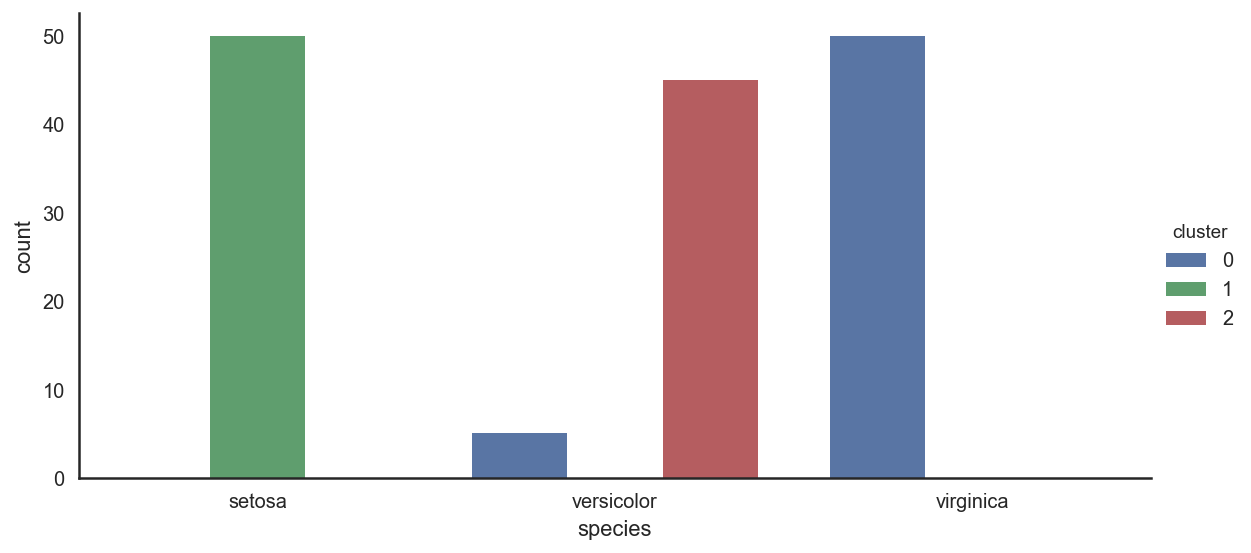

In [10]:
with sns.axes_style('white'):
    g = sns.factorplot( "species", data = iris, aspect = 2., kind = 'count', hue = "cluster" )